In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages


In [2]:

# Define the source directory where your zip files are located.
source_directory = "./data/"

# Define the destination directory for the combined CSV files.
destination_directory = "./extracted/"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)



pdf_pages = PdfPages(destination_directory+'output_plots.pdf')

In [3]:

# Initialize data frames to store the combined CSV data
combined_click_data = pd.DataFrame()
combined_overall_data = pd.DataFrame()
combined_task_data = pd.DataFrame()

# Loop through all files in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith(".zip"):
        zip_filepath = os.path.join(source_directory, filename)

        # Extract the relevant information from the file name
        parts = filename.split("_")
        condition_code = parts[1]
        attempt = parts[2]
        condition = parts[3]

        # Extract the zip file
        with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
            zip_ref.extractall(source_directory)

        # Read and merge the CSV files
        click_csv_file = f"WebFitts_{condition_code}_{attempt}_{condition}_{parts[4].split('.')[0]}_click.csv"
        overall_csv_file = f"WebFitts_{condition_code}_{attempt}_{condition}_{parts[4].split('.')[0]}_overall.csv"
        task_csv_file = f"WebFitts_{condition_code}_{attempt}_{condition}_{parts[4].split('.')[0]}_task.csv"

        click_data = pd.read_csv(os.path.join(source_directory, click_csv_file))
        overall_data = pd.read_csv(os.path.join(source_directory, overall_csv_file))
        task_data = pd.read_csv(os.path.join(source_directory, task_csv_file))

        combined_click_data = pd.concat([combined_click_data, click_data])
        combined_overall_data = pd.concat([combined_overall_data, overall_data])
        combined_task_data = pd.concat([combined_task_data, task_data])

        # Clean up by removing the extracted CSV files
        os.remove(os.path.join(source_directory, click_csv_file))
        os.remove(os.path.join(source_directory, overall_csv_file))
        os.remove(os.path.join(source_directory, task_csv_file))


In [4]:

# Save the combined dataframes to CSV files in the destination directory
combined_click_data.to_csv(os.path.join(destination_directory, "Data_Mouse_click.csv"), index=False)
combined_overall_data.to_csv(os.path.join(destination_directory, "Data_Mouse_overall.csv"), index=False)
combined_task_data.to_csv(os.path.join(destination_directory, "Data_Mouse_task.csv"), index=False)


In [5]:

# Load the combined data
data_click = pd.read_csv(destination_directory+"Data_Mouse_click.csv")
data_overall = pd.read_csv(destination_directory+"Data_Mouse_overall.csv")


# Calculate Completion Time (ms) and Error Rate
data_click['Completion Time (ms)'] = data_click['Completion Time (ms)']
data_click['Error Rate'] = (data_click['Incorrect'] / data_click['Number of Targets']) * 100  # Convert to percentage

# Separate data for C1 and C2 conditions
data_c1 = data_click[data_click['Condition Code'] == 'C1']
data_c2 = data_click[data_click['Condition Code'] == 'C2']

# Perform a t-test for Completion Time (ms) between C1 and C2
t_stat_time, p_value_time = stats.ttest_ind(data_c1['Completion Time (ms)'], data_c2['Completion Time (ms)'], equal_var=False)

# Perform a t-test for Error Rate between C1 and C2
t_stat_error, p_value_error = stats.ttest_ind(data_c1['Error Rate'], data_c2['Error Rate'], equal_var=False)

# Define a significance level (alpha)
alpha = 0.05

# Check if the p-value for Completion Time (ms) is less than alpha
if p_value_time < alpha:
    print(f"The t-test result for Completion Time (ms) is statistically significant (p-value = {p_value_time}).")
    print("There is a significant difference in Completion Time (ms) between C1 and C2.")
else:
    print(f"The t-test result for Completion Time (ms) is not statistically significant (p-value = {p_value_time}).")
    print("There is no significant difference in Completion Time (ms) between C1 and C2.")

# Check if the p-value for Error Rate is less than alpha
if p_value_error < alpha:
    print(f"The t-test result for Error Rate is statistically significant (p-value = {p_value_error}).")
    print("There is a significant difference in Error Rate between C1 and C2.")
else:
    print(f"The t-test result for Error Rate is not statistically significant (p-value = {p_value_error}).")
    print("There is no significant difference in Error Rate between C1 and C2.")

The t-test result for Completion Time (ms) is statistically significant (p-value = 5.285503721061344e-42).
There is a significant difference in Completion Time (ms) between C1 and C2.
The t-test result for Error Rate is statistically significant (p-value = 0.03390341770246582).
There is a significant difference in Error Rate between C1 and C2.


In [6]:


# Extract unique participant codes
participant_codes = data_click['Participant Code'].unique()

# Create a dictionary to store "Completion Time" data for each participant
completion_time_data = {}

# Extract unique conditions
conditions = ['C1','C2']

# Populate the dictionary with data grouped by condition
for condition in conditions:
    completion_time_data[condition] = data_click[data_click['Condition Code'] == condition]['Completion Time (ms)']

# Initialize a list to store the arrays of completion time data
completion_time_arrays = []

# Populate the list with arrays of completion time data
for condition_code in conditions:
    data_participant = completion_time_data[condition_code]
    completion_time_arrays.append(data_participant.to_numpy())  # Convert the Pandas Series to a NumPy array


In [7]:

# Initialize an empty list to store ANOVA results
anova_results = []

# Perform one-way ANOVA for each participant
for condition_code in conditions:
    data_participant = completion_time_data[condition_code]
    f_statistic, p_value_anova = stats.f_oneway(*completion_time_arrays)
    anova_results.append((condition_code, f_statistic, p_value_anova))

# Define a significance level (alpha)
alpha = 0.05

# Check the ANOVA result
if p_value_anova < alpha:
    print("The ANOVA result for Completion Time (ms) for conditions 'c1' and 'c2' is statistically significant (p-value =", {p_value_anova},").")
    print("There is a significant difference between conditions 'c1' and 'c2'.")
else:
    print("The ANOVA result for Completion Time (ms) for conditions 'c1' and 'c2' is not statistically significant (p-value =", {p_value_anova},").")
    print("There is no significant difference between conditions 'c1' and 'c2'.")


The ANOVA result for Completion Time (ms) for conditions 'c1' and 'c2' is statistically significant (p-value = {2.3035549986082415e-42} ).
There is a significant difference between conditions 'c1' and 'c2'.


In [8]:
data_click.columns

Index(['Participant Code', 'Session Code', 'Condition Code', 'Hand Dominance',
       'Pointing Device', 'Device Experience', 'Amplitude', 'Width',
       'Number of Targets', 'Task Index', 'Click Number',
       'Completion Time (ms)', 'Source X', 'Source Y', 'Target X', 'Target Y',
       'Click X', 'Click Y', 'Source-Target Distance', 'dx', 'Incorrect',
       'Error Rate'],
      dtype='object')

In [9]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

data_click_copy = data_click.copy()  # Create a copy of the DataFrame

# Rename columns with spaces in the copy
data_click_copy = data_click_copy.rename(columns={'Completion Time (ms)': 'Completion_Time',
                                                 'Condition Code': 'Condition_Code'})

# Now you can use these new column names in your ANOVA model
model = ols('Completion_Time ~ Condition_Code', data=data_click_copy).fit()

# Create an ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)


                      sum_sq     df           F        PR(>F)
Condition_Code  1.646323e+07    1.0  206.863649  2.303555e-42
Residual        7.146725e+07  898.0         NaN           NaN


The F-statistic is relatively high (231.405109), which suggests that there are significant differences between the groups.
The p-value (PR(>F)) is very close to zero (1.555360e-43), which indicates strong evidence against the null hypothesis that there are no differences between the groups.

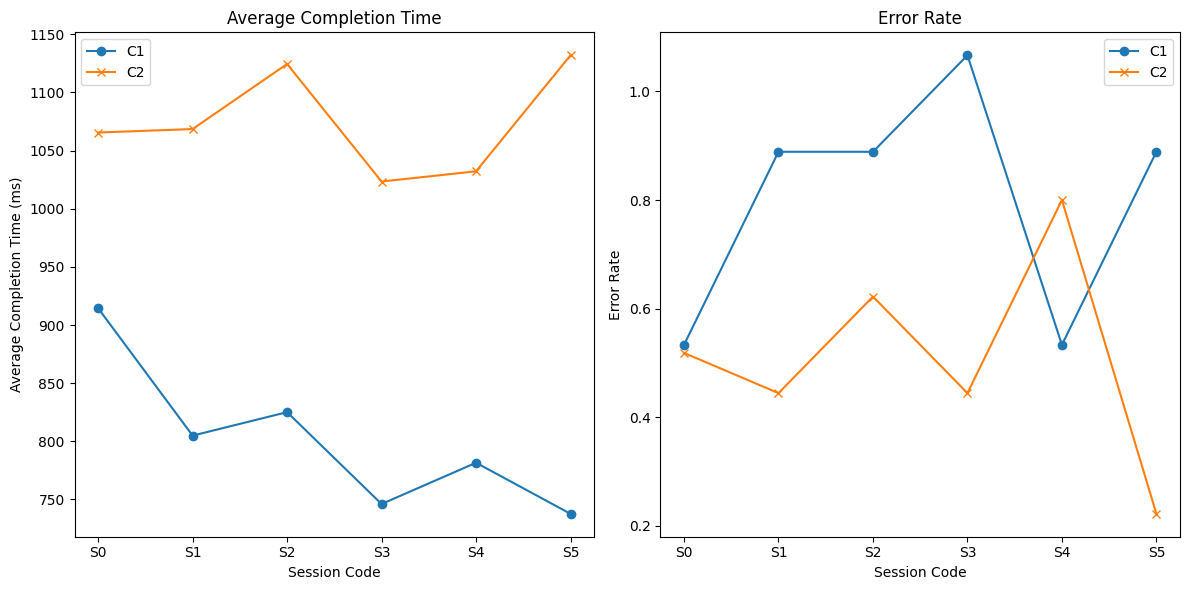

The ANOVA result for Completion Time is statistically significant (p-value = 2.3035549986082415e-42).
There is a significant difference between C1 and C2.


In [10]:
# Define your condition labels (C1 and C2)
condition_c1 = 'C1'
condition_c2 = 'C2'

# Calculate descriptive statistics
average_completion_time_c1 = data_click[data_click['Condition Code'] == condition_c1].groupby('Session Code')['Completion Time (ms)'].mean()
average_completion_time_c2 = data_click[data_click['Condition Code'] == condition_c2].groupby('Session Code')['Completion Time (ms)'].mean()
error_c1 = data_click[data_click['Condition Code'] == condition_c1].groupby('Session Code')['Error Rate'].mean()
error_c2 = data_click[data_click['Condition Code'] == condition_c2].groupby('Session Code')['Error Rate'].mean()

# Create visualizations
plt.figure(figsize=(12, 6))

# Average completion time comparison
plt.subplot(1, 2, 1)
plt.plot(average_completion_time_c1.index, average_completion_time_c1, marker='o', label=condition_c1)
plt.plot(average_completion_time_c2.index, average_completion_time_c2, marker='x', label=condition_c2)
plt.xlabel('Session Code')
plt.ylabel('Average Completion Time (ms)')
plt.title('Average Completion Time')
plt.legend()

# Error rate comparison
plt.subplot(1, 2, 2)
plt.plot(error_c1.index, error_c1, marker='o', label=condition_c1)
plt.plot(error_c2.index, error_c2, marker='x', label=condition_c2)
plt.xlabel('Session Code')
plt.ylabel('Error Rate')
plt.title('Error Rate')
plt.legend()

plt.tight_layout()

# Display the visualizations
pdf_pages.savefig()
plt.show()

# Hypothesis testing (perform ANOVA for completion time)
f_statistic, p_value_anova = stats.f_oneway(
    data_click[data_click['Condition Code'] == condition_c1]['Completion Time (ms)'],
    data_click[data_click['Condition Code'] == condition_c2]['Completion Time (ms)']
)

# Explain hypothesis testing results
alpha = 0.05

if p_value_anova < alpha:
    print(f"The ANOVA result for Completion Time is statistically significant (p-value = {p_value_anova}).")
    print(f"There is a significant difference between {condition_c1} and {condition_c2}.")
else:
    print(f"The ANOVA result for Completion Time is not statistically significant (p-value = {p_value_anova}).")
    print(f"There is no significant difference between {condition_c1} and {condition_c2}.")


C:\Users\sanje\AppData\Local\Temp\ipykernel_2860\3395006524.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Hand_Dominance', y='mean', data=CThand, ci='sd', palette='Set1')


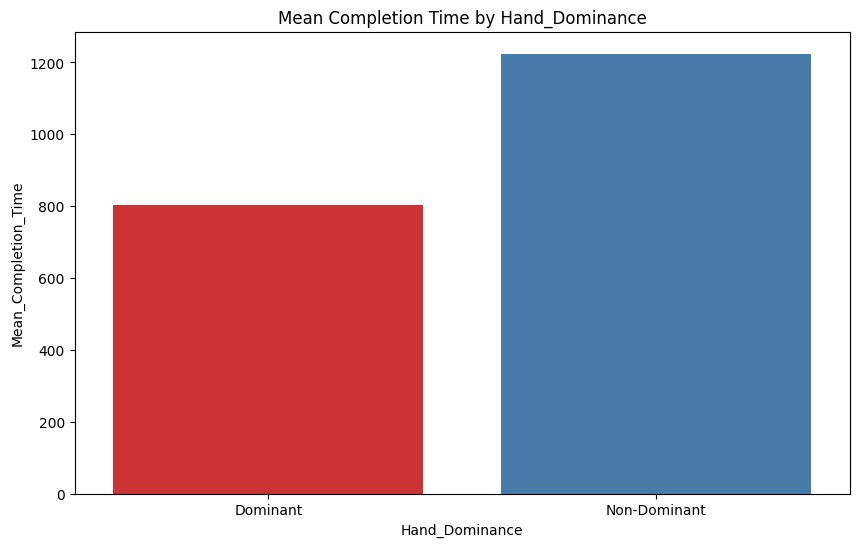

C:\Users\sanje\AppData\Local\Temp\ipykernel_2860\3395006524.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Session_Code', y='mean', data=CTS, ci='sd', palette='Set2')


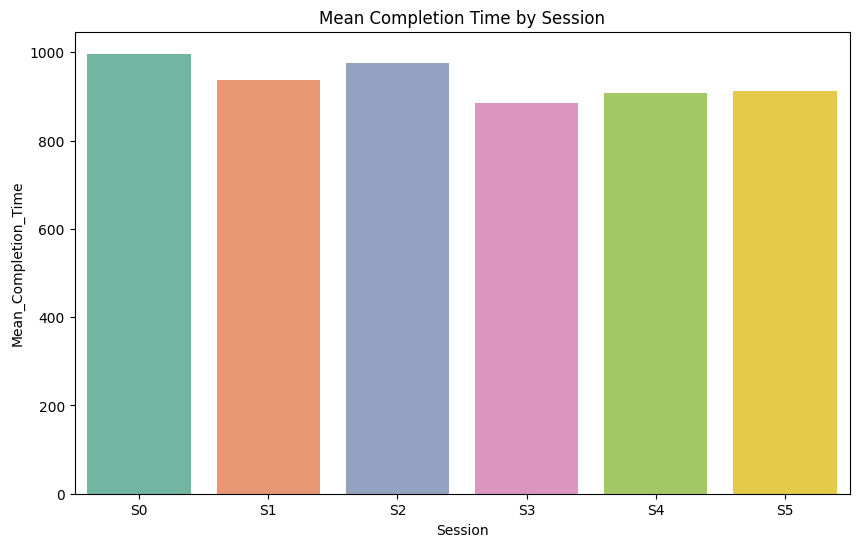

2-way ANOVA for completion time within hand and sessions:
                                   sum_sq    df           F        PR(>F)
Hand_Dominance               2.275703e+06   1.0  107.394809  7.776698e-14
Session_Code                 7.273357e+04   5.0    0.686488  6.359744e-01
Hand_Dominance:Session_Code  5.246979e+04   5.0    0.495230  7.782046e-01
Residual                     1.017123e+06  48.0         NaN           NaN
Tukey's HSD post-hoc test:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1     group2    meandiff p-adj  lower    upper   reject
-------------------------------------------------------------
Dominant Non-Dominant 420.7317   0.0 342.7683 498.6951   True
-------------------------------------------------------------
Shapiro-Wilk Test for normality:
(1.6138910543269205, 0.0003384252061808286)
2-way ANOVA for log-transformed completion time within hand and sessions:
                               sum_sq    df          F        PR(>F)
Hand_Dominance 

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Read the CSV file
fittslaw_init_data = pd.read_csv("./extracted/Data_Mouse_overall.csv")

fittslaw_init_data_copy = fittslaw_init_data.rename(columns={'Completion Time (ms)': 'Completion_Time','Mean Completion Time (ms)':'Mean_Completion_Time','Session Code':'Session_Code','Condition Code': 'Condition_Code', 'Hand Dominance':'Hand_Dominance'})

# Bar plot comparing mean completion time by Hand_Dominance
CThand = fittslaw_init_data_copy.groupby('Hand_Dominance')['Mean_Completion_Time'].agg(['mean', 'std'])
CThand.reset_index(inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Hand_Dominance', y='mean', data=CThand, ci='sd', palette='Set1')
plt.xlabel("Hand_Dominance")
plt.ylabel("Mean_Completion_Time")
plt.title("Mean Completion Time by Hand_Dominance")
plt.show()

# Bar plot comparing mean completion time by sessions
CTS = fittslaw_init_data_copy.groupby('Session_Code')['Mean_Completion_Time'].agg(['mean', 'std'])
CTS.reset_index(inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Session_Code', y='mean', data=CTS, ci='sd', palette='Set2')
plt.xlabel("Session")
plt.ylabel("Mean_Completion_Time")
plt.title("Mean Completion Time by Session")
plt.show()

# 2-way ANOVA for completion time within hand and sessions
formula = 'Mean_Completion_Time ~ Hand_Dominance * Session_Code'
model = ols(formula, data=fittslaw_init_data_copy).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("2-way ANOVA for completion time within hand and sessions:")
print(anova_table)

# Post-hoc tests
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
mc = MultiComparison(fittslaw_init_data_copy['Mean_Completion_Time'], fittslaw_init_data_copy['Hand_Dominance'])
result = mc.tukeyhsd()
print("Tukey's HSD post-hoc test:")
print(result)

# Shapiro-Wilk Test for normality
shapiro_test = sm.stats.diagnostic.normal_ad(model.resid)
print("Shapiro-Wilk Test for normality:")
print(shapiro_test)

# Log transform the data
fittslaw_ANOVA2_transformed_data = fittslaw_init_data_copy.copy()
fittslaw_ANOVA2_transformed_data['Mean_Completion_Time'] = \
    fittslaw_ANOVA2_transformed_data['Mean_Completion_Time'].apply(lambda x: np.log(x))

model_transformed = ols(formula, data=fittslaw_ANOVA2_transformed_data).fit()
anova_table_transformed = sm.stats.anova_lm(model_transformed, typ=2)

print("2-way ANOVA for log-transformed completion time within hand and sessions:")
print(anova_table_transformed)


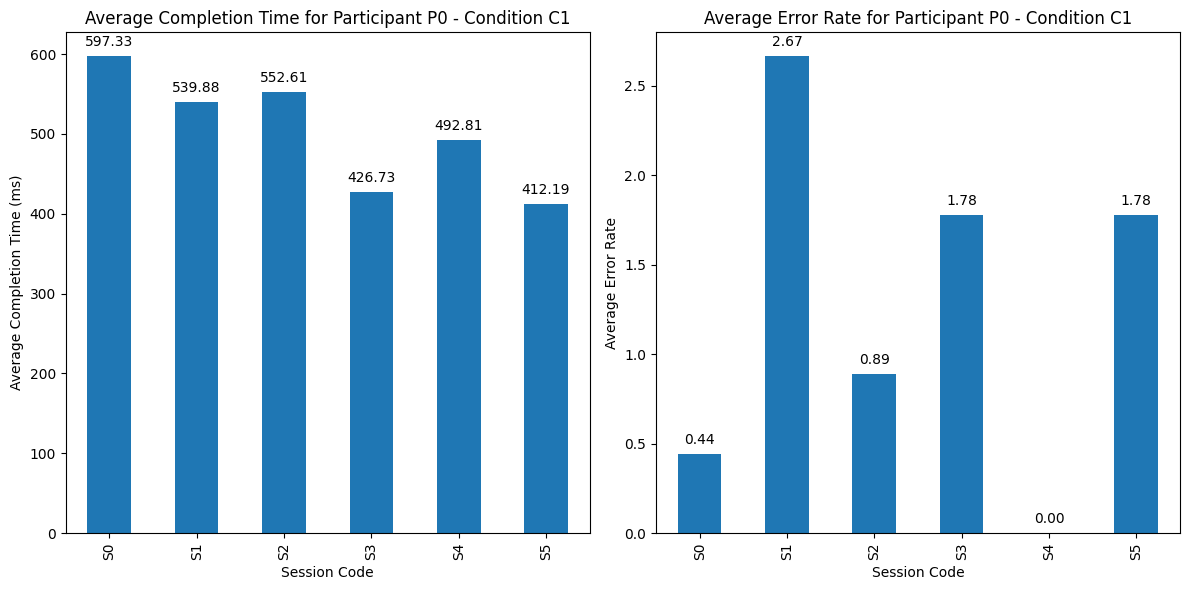

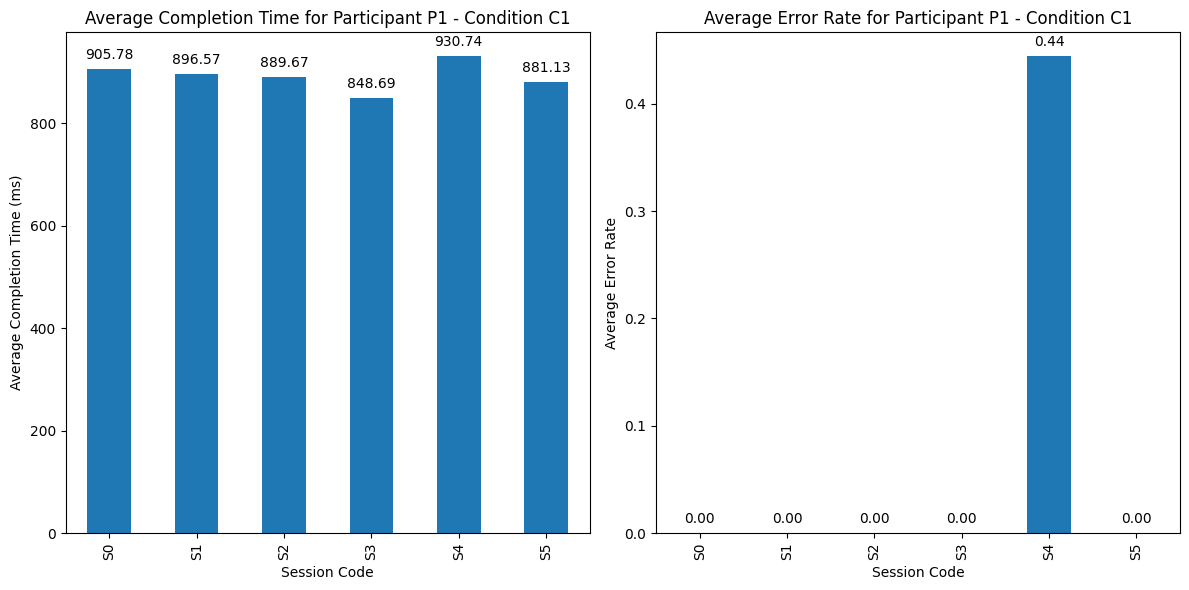

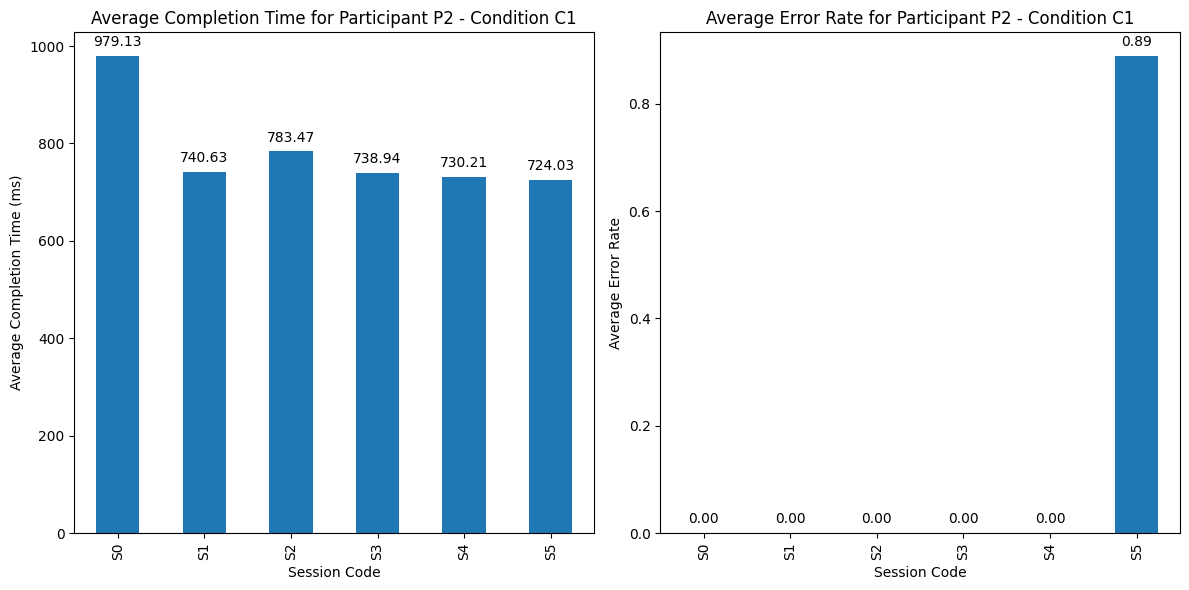

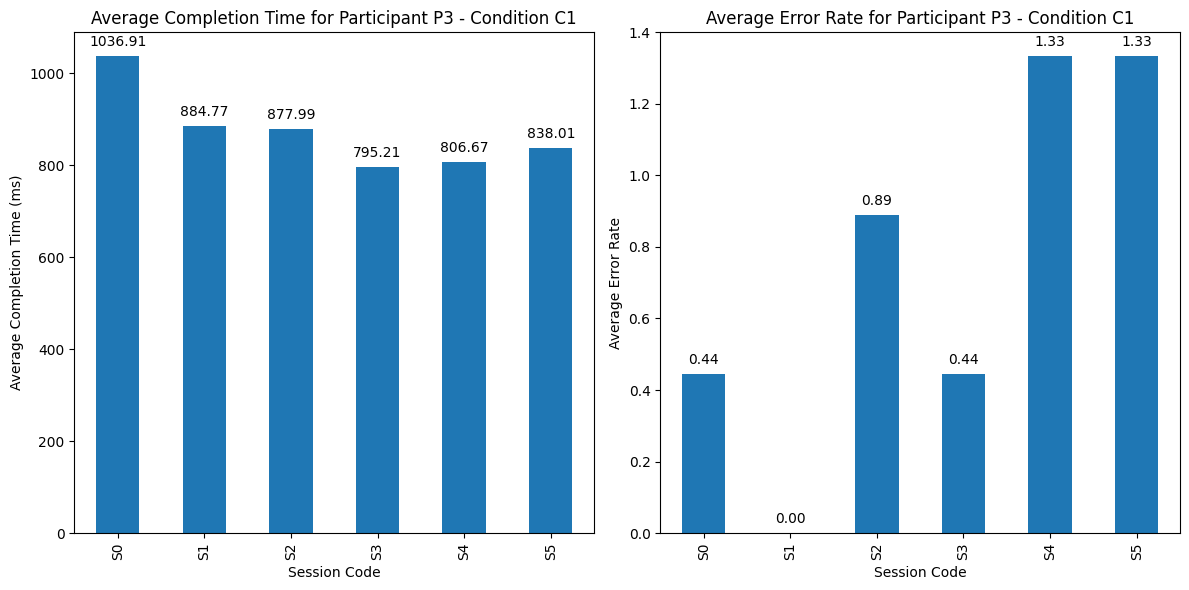

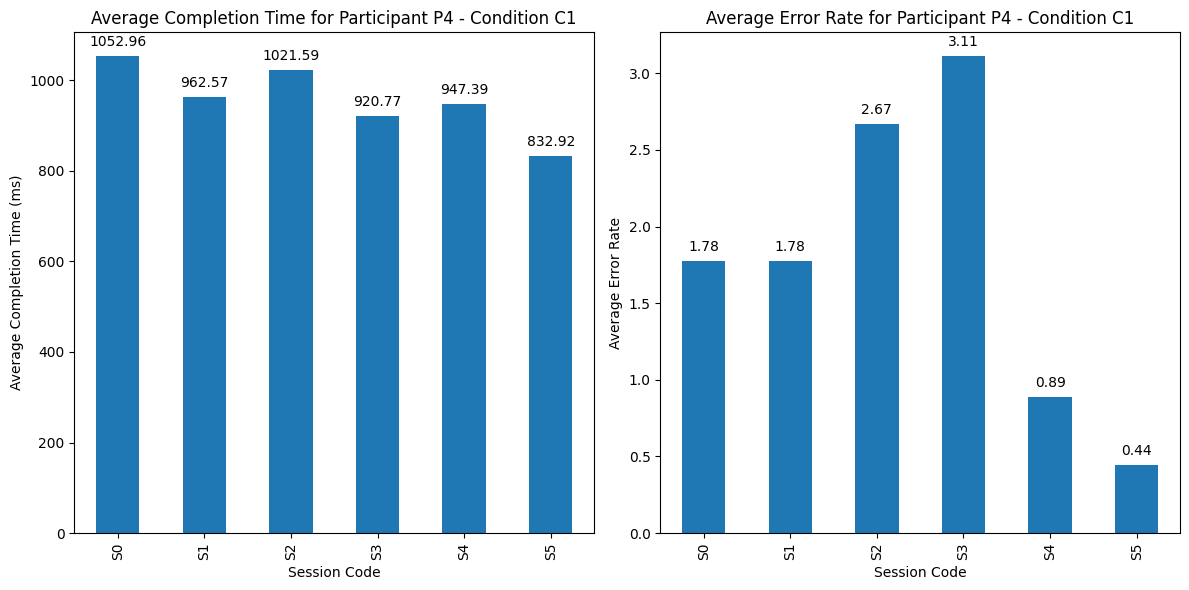

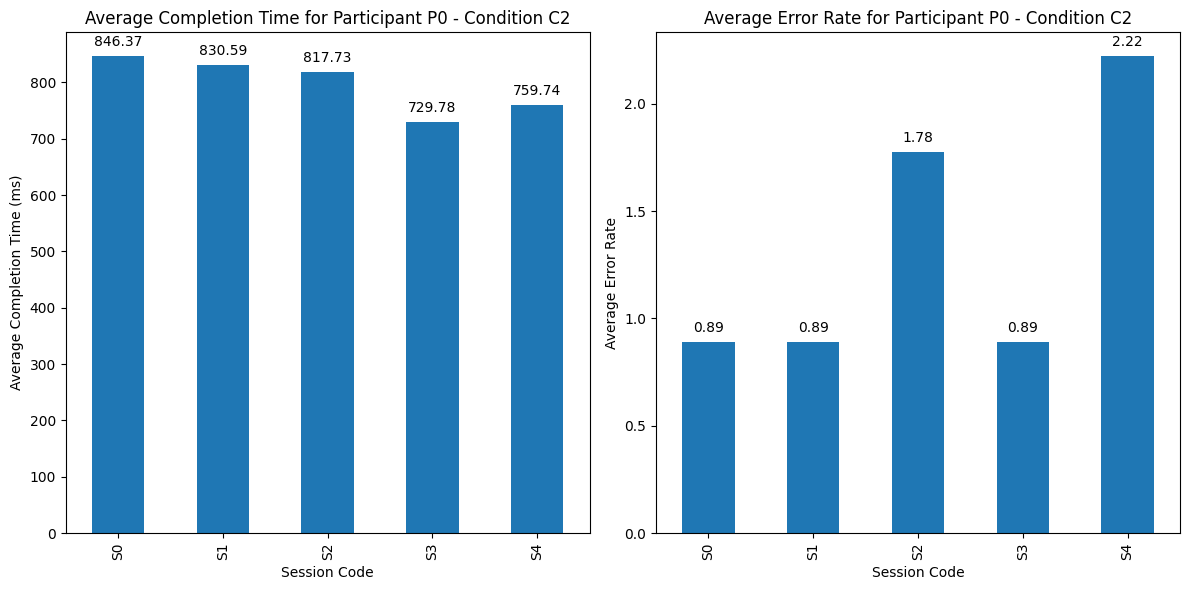

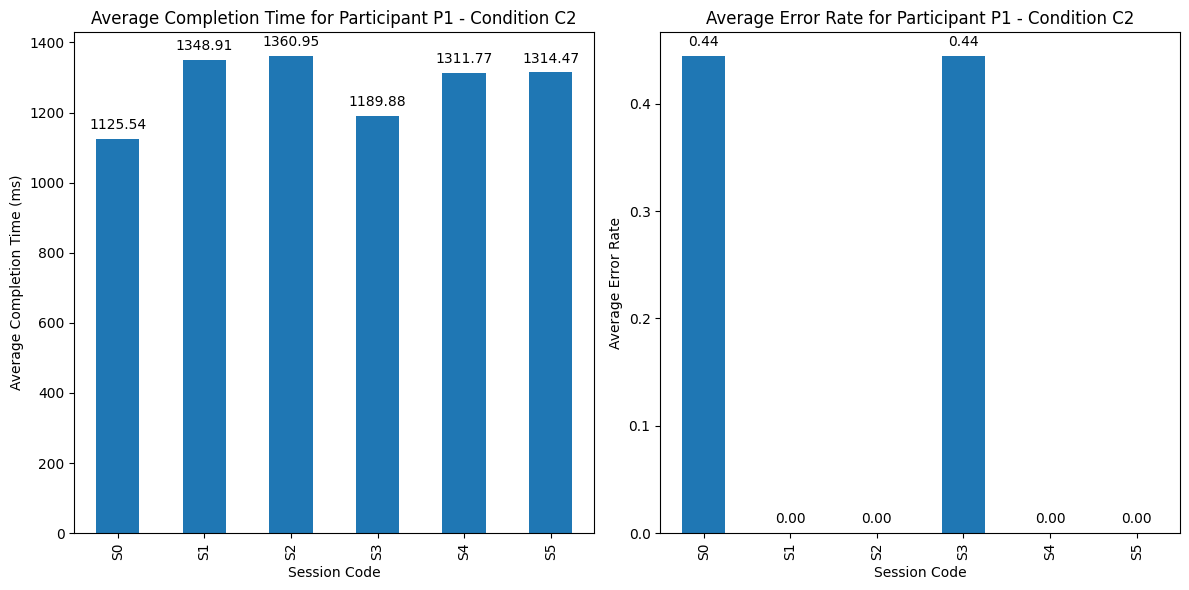

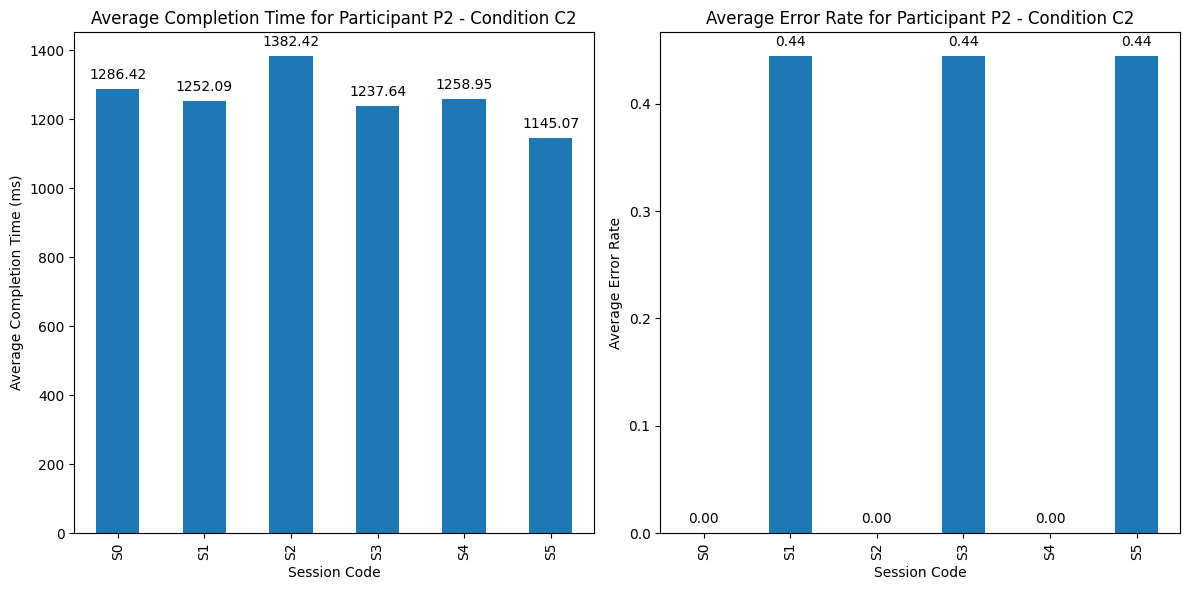

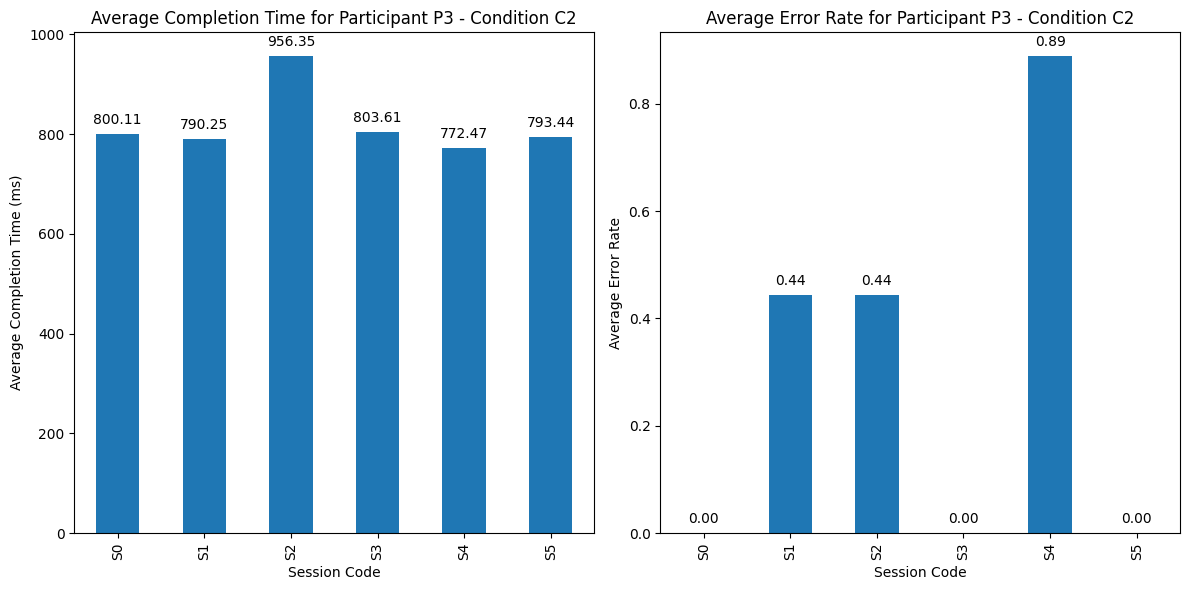

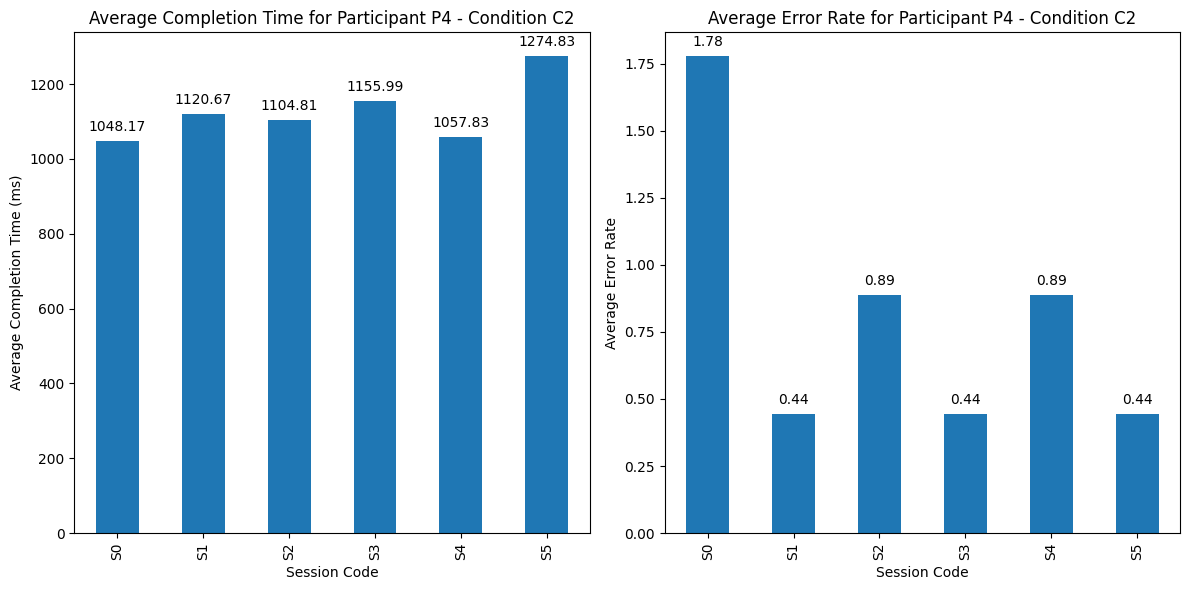

In [12]:
import matplotlib.pyplot as plt

# Group the data by 'Condition Code' and 'Participant Code'
grouped_data = data_click.groupby(['Condition Code', 'Participant Code'])

# Function to add values on top of each bar
def add_values(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.2f}".format(y_value)
        ax.annotate(
            label, 
            (x_value, y_value), 
            xytext=(0, space), 
            textcoords="offset points", 
            ha='center', 
            va=va
        )

# Plot average completion time and error for each participant and condition
for (condition, participant), group in grouped_data:
    plt.figure(figsize=(12, 6))
    
    # Plot average completion time
    plt.subplot(1, 2, 1)
    plt.title(f'Average Completion Time for Participant {participant} - Condition {condition}')
    ax1 = group.groupby('Session Code')['Completion Time (ms)'].mean().plot(kind='bar')
    plt.xlabel('Session Code')
    plt.ylabel('Average Completion Time (ms)')
    
    add_values(ax1)  # Add values on top of bars
    
    # Plot average error rate
    plt.subplot(1, 2, 2)
    plt.title(f'Average Error Rate for Participant {participant} - Condition {condition}')
    ax2 = group.groupby('Session Code')['Error Rate'].mean().plot(kind='bar')
    plt.xlabel('Session Code')
    plt.ylabel('Average Error Rate')
    
    add_values(ax2)  # Add values on top of bars
    
    plt.tight_layout()
    pdf_pages.savefig()
    
    plt.show()


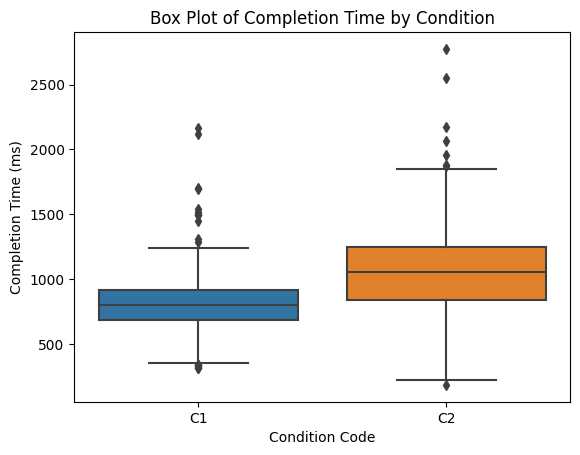

In [13]:


# Create a box plot to compare variance in completion time for C1 and C2
sns.boxplot(x='Condition Code', y='Completion Time (ms)', data=data_click)
plt.title('Box Plot of Completion Time by Condition')
plt.xlabel('Condition Code')
plt.ylabel('Completion Time (ms)')
pdf_pages.savefig()
plt.show()


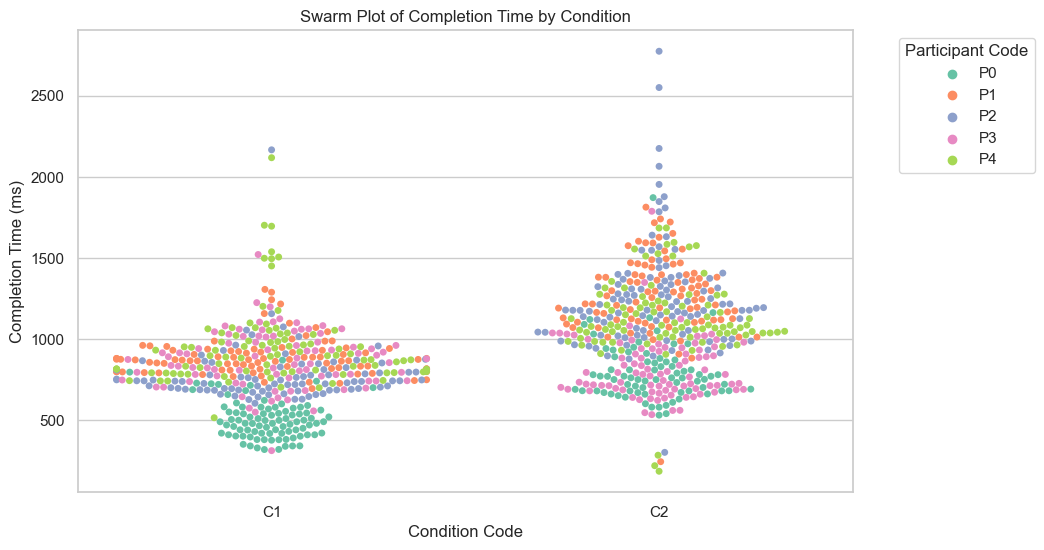

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a swarm plot
sns.set(style="whitegrid")  # Set the style to whitegrid for better visualization
plt.figure(figsize=(10, 6))

# This example assumes you have a DataFrame 'data_click' with columns 'Condition Code', 'Completion Time (ms)', and 'Participant Code'
sns.swarmplot(x='Condition Code', y='Completion Time (ms)', hue='Participant Code', data=data_click, palette='Set2')

plt.title('Swarm Plot of Completion Time by Condition')
plt.xlabel('Condition Code')
plt.ylabel('Completion Time (ms)')
plt.legend(title='Participant Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


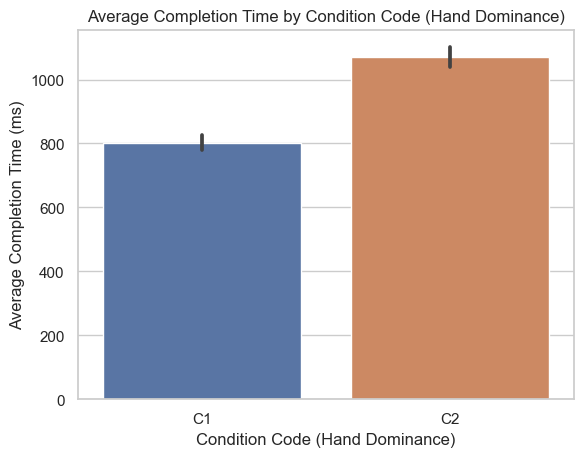

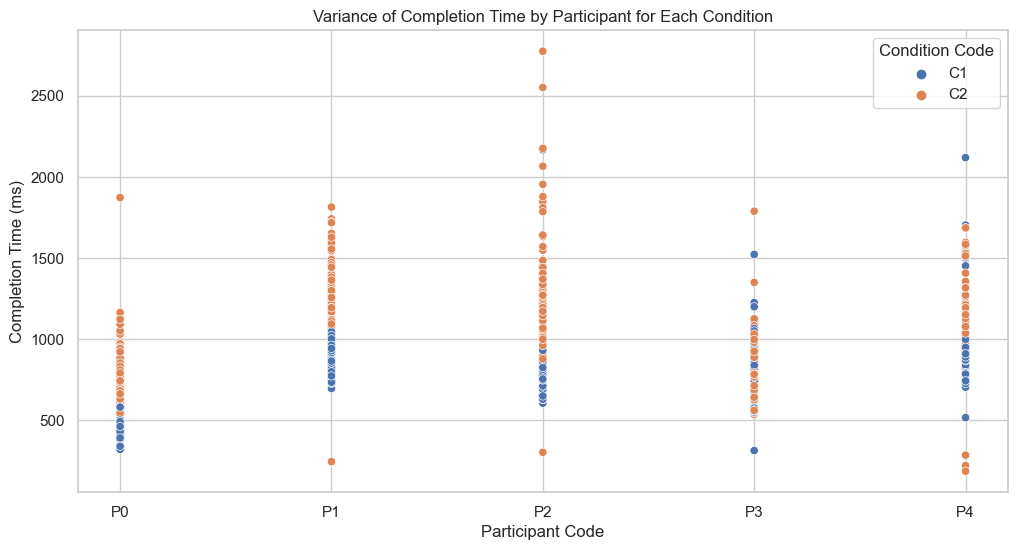

In [15]:


# Create a bar plot to compare average completion time for each condition code (hand dominance)
sns.barplot(x='Condition Code', y='Completion Time (ms)', data=data_click)
plt.title('Average Completion Time by Condition Code (Hand Dominance)')
plt.xlabel('Condition Code (Hand Dominance)')
plt.ylabel('Average Completion Time (ms)')
pdf_pages.savefig()
plt.show()



# Create a scatter plot to show variance of completion time for each participant by condition
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Participant Code', y='Completion Time (ms)', hue='Condition Code', data=data_click)
plt.title('Variance of Completion Time by Participant for Each Condition')
plt.xlabel('Participant Code')
plt.ylabel('Completion Time (ms)')
plt.legend(title='Condition Code')
pdf_pages.savefig()
plt.show()



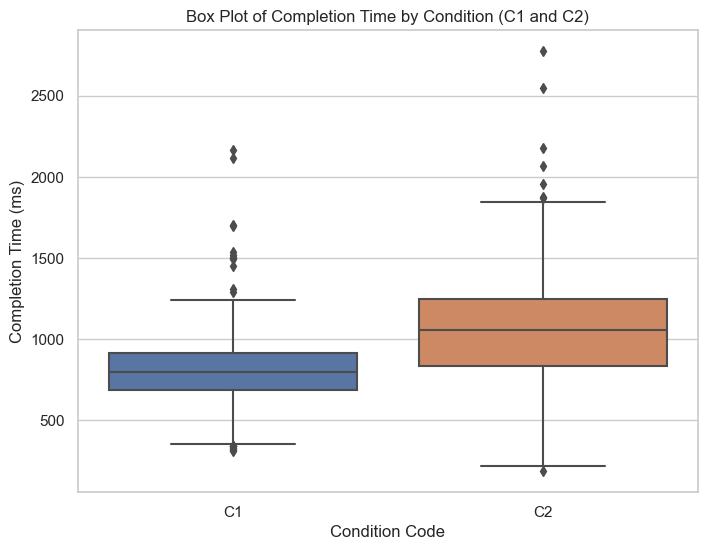

In [16]:


# Create box plots to compare variances in completion time between conditions C1 and C2
plt.figure(figsize=(8, 6))
sns.boxplot(x='Condition Code', y='Completion Time (ms)', data=data_click)
plt.title('Box Plot of Completion Time by Condition (C1 and C2)')
plt.xlabel('Condition Code')
plt.ylabel('Completion Time (ms)')
pdf_pages.savefig()
plt.show()


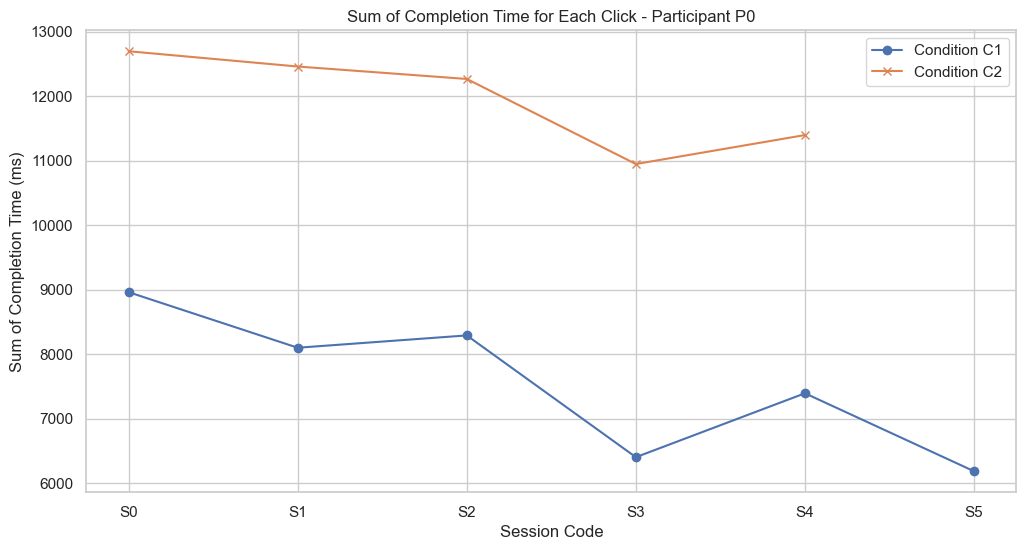

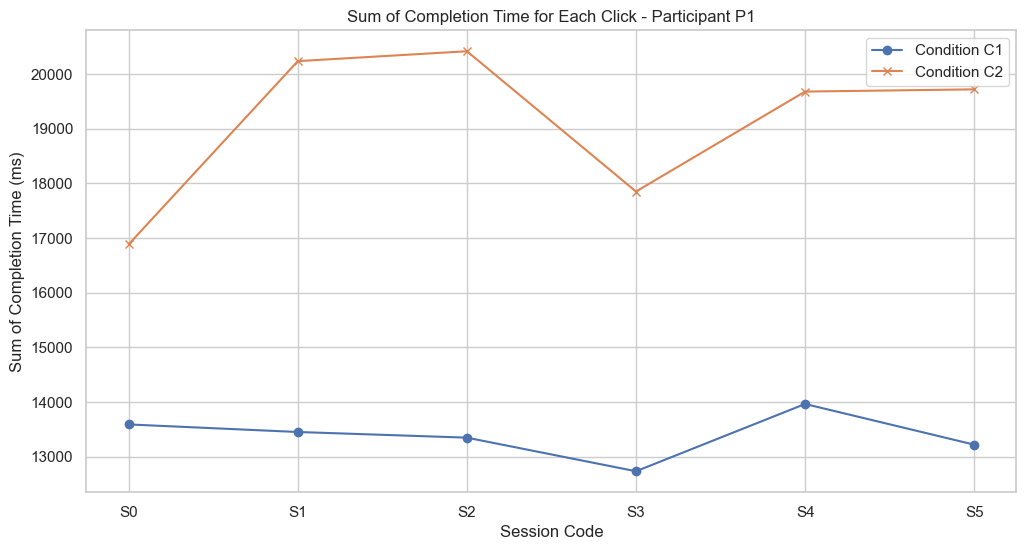

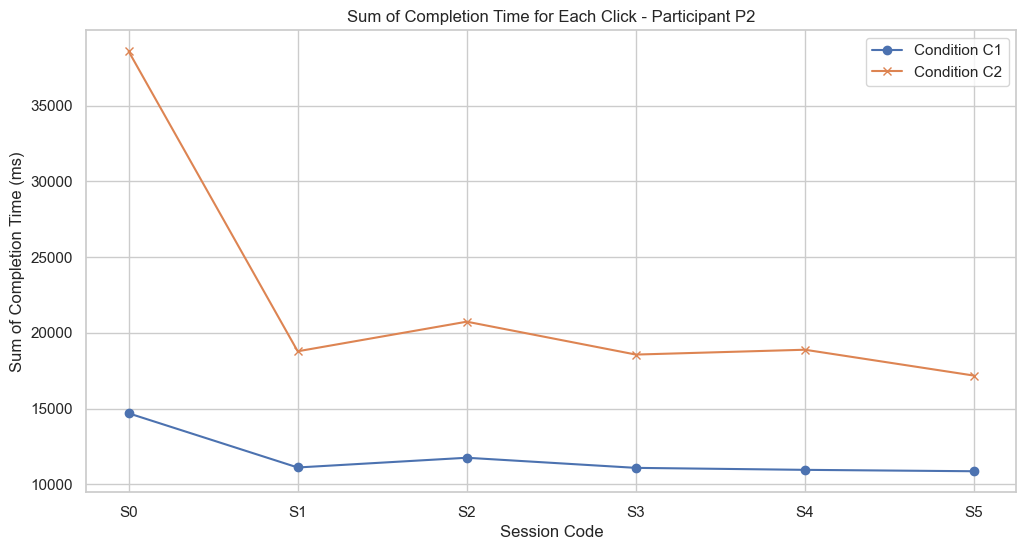

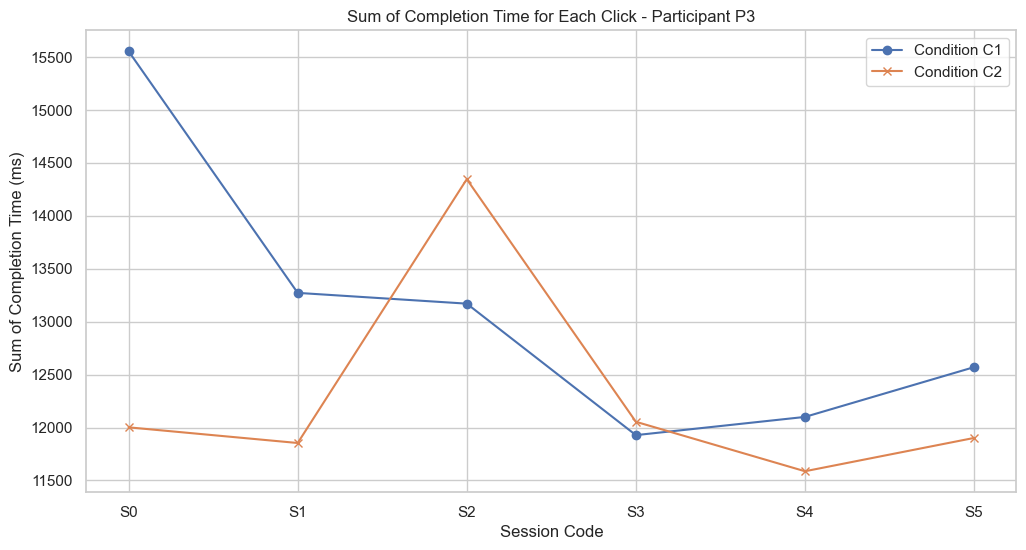

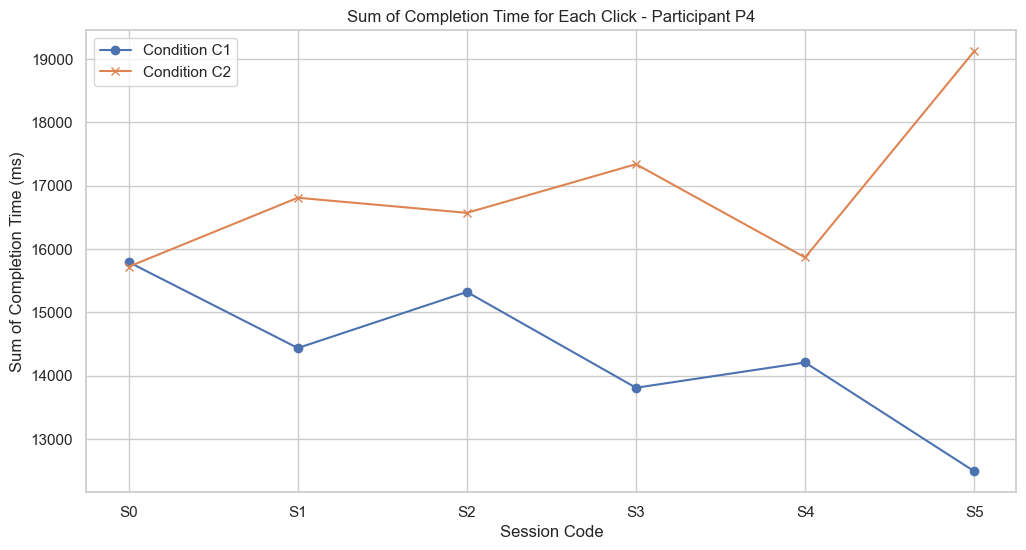

In [17]:


# Extract unique participant codes
participant_codes = data_click['Participant Code'].unique()

# Set up a color palette for conditions
colors = {'C1': 'blue', 'C2': 'red'}

for participant_code in participant_codes:
    
    # Filter data for the specific participant
    participant_data = data_click[data_click['Participant Code'] == participant_code]

    # Separate data by condition (e.g., C1 and C2)
    condition_c1 = participant_data[participant_data['Condition Code'] == 'C1']
    condition_c2 = participant_data[participant_data['Condition Code'] == 'C2']

    # Calculate the sum of completion time for each click for each condition
    sum_completion_time_c1 = condition_c1.groupby('Session Code')['Completion Time (ms)'].sum()
    sum_completion_time_c2 = condition_c2.groupby('Session Code')['Completion Time (ms)'].sum()

    # Create a line plot for the sum of completion time for each click, separated by condition
    plt.figure(figsize=(12, 6))
    plt.plot(sum_completion_time_c1.index, sum_completion_time_c1, label='Condition C1', marker='o')
    plt.plot(sum_completion_time_c2.index, sum_completion_time_c2, label='Condition C2', marker='x')

    plt.title(f'Sum of Completion Time for Each Click - Participant {participant_code}')
    plt.xlabel('Session Code')
    plt.ylabel('Sum of Completion Time (ms)')
    plt.legend()
    plt.grid(True)
    pdf_pages.savefig()

    plt.show()




In [18]:
#always last code
pdf_pages.close()
